<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/image/Inference_image_classification_NSWF_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model https://huggingface.co/google/vit-base-patch16-224-in21k

### From Hugging Face

####Vision Transformer (base-sized model)
Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

Disclaimer: The team releasing ViT did not write a model card for this model so this model card has been written by the Hugging Face team.

### Model description
The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

#### Note
This model does not provide any fine-tuned heads, as these were zero'd by Google researchers. However, the model does include the pre-trained pooler, which can be used for downstream tasks (such as image classification).

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.

In [4]:

# ! pip install datasets transformers
# ! pip install accelerate wandb bitsandbytes -U -q

In [1]:
import wandb

# https://wandb.ai/site

PROJECT = "NSFW-fine_tune"
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
DATASET = "NSFW"
wandb.init(project=PROJECT, # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes ="Classification Fine Tune NSFW dataset with google/vit-base-patch16-224-in21k") # the Hyperparameters I want to keep track of

wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


In [2]:
run = wandb.init()
artifact = run.use_artifact('olonok69/NSFW-fine_tune/nsfw_3600:v1', type='model')
artifact_dir = artifact.download("model")

wandb: Downloading large artifact nsfw_3600:v1, 327.34MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:14.8


In [64]:
artifact_dir = artifact.download("model")

wandb: Downloading large artifact nsfw_3600:v1, 327.34MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:14.9


In [3]:
from transformers import ViTImageProcessor,  ViTForImageClassification
from PIL import Image as PImage
import matplotlib.pyplot as plt
import torch
from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
import numpy as np
from IPython.display import Video

2024-01-15 16:32:15.914558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 16:32:16.433395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 16:32:19.250846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [114]:
#production_id_3997798 (2160p).mp4
path_video= "images/production_id_3997798 (2160p).mp4" # AVI
#path_video= "images/file_example_MOV_480_700kB.mov" # Mov

#Video(path_video, embed=True, width=200,    height=200,)

In [27]:
import cv2
from typing import Any, Callable, List, Optional, Sequence, Tuple
from tqdm import tqdm  # type: ignore

In [30]:
import numpy as np
import numpy.typing
from enum import auto, Enum
NDFloat32Array = np.typing.NDArray[np.float32]
NDUInt8Array = np.typing.NDArray[np.uint8]

In [9]:
cap = cv2.VideoCapture(path_video)

In [11]:
fps = cap.get(cv2.CAP_PROP_FPS) 

In [12]:
fps

50.0

In [13]:
label_dic={"drawings":0, "hentai": 1,"neutral":2, "porn": 3,"sexy": 4}

In [88]:
processor = ViTImageProcessor.from_pretrained(artifact_dir)
model = ViTForImageClassification.from_pretrained(artifact_dir)
model = model.to("cuda")

In [89]:
video_writer: Optional[cv2.VideoWriter] = None  # pylint: disable=no-member
input_frames: List[NDFloat32Array] = []
nsfw_probability = 0.0
nsfw_probabilities: List[float] = []
frame_count = 0

In [90]:
int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

738

In [91]:
pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

  0%|▏                                                                                                                                                                       | 1/738 [03:48<46:46:52, 228.51s/it]


In [92]:
class Aggregation(str, Enum):
    MEAN = auto()
    MEDIAN = auto()
    MAX = auto()
    MIN = auto()


def _get_aggregation_fn(aggregation: Aggregation) -> Callable[[NDFloat32Array], float]:
    def fn(x: NDFloat32Array) -> float:
        agg: Any = {
            Aggregation.MEAN: np.mean,
            Aggregation.MEDIAN: np.median,
            Aggregation.MAX: np.max,
            Aggregation.MIN: np.min,
        }[aggregation]
        return float(agg(x))

    return fn

In [93]:
aggregation = Aggregation.MEAN
frame_interval = 8
aggregation_size= 8
batch_size =  8

In [94]:
ret, bgr_frame = cap.read()

In [95]:
frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

In [96]:
inputs = processor(images=frame, return_tensors="np")

In [97]:
inputs['pixel_values'].shape

(1, 3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


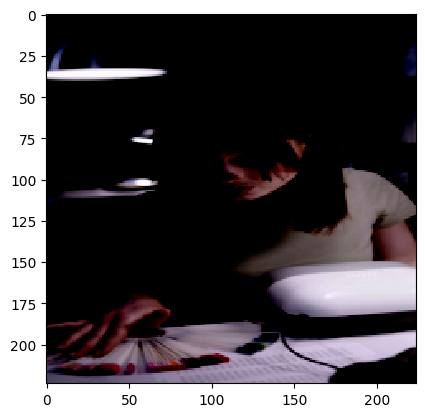

In [98]:
plt.imshow(np.transpose(inputs['pixel_values'][0], (1, 2, 0)), interpolation='nearest')

In [100]:
inputs = processor(images=frame, return_tensors="pt")
inputs =  inputs.to("cuda")
outputs = model(**inputs)

In [101]:
logits = outputs.logits

In [102]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: neutral


In [105]:
probs= torch.softmax(logits, dim=1).cpu().detach().numpy()

In [106]:
def get_key(dict, value):
  for key, val in dict.items():
    if val == value:
      return key
  return "Value not found"





In [107]:
probs = list(probs[0])
probs

[0.12962694, 0.0020236685, 0.8652834, 0.0017234131, 0.0013424733]

In [108]:
output_probs = {}
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)
  output_probs[label]= prob

drawings 0.12962694
hentai 0.0020236685
neutral 0.8652834
porn 0.0017234131
sexy 0.0013424733


In [66]:
# we have define non-suitable for work as the sum of this classes > 0.5 (in fact it is a threshold defined by user)
prob_nsfw = output_probs["sexy"] + output_probs["hentai"] + output_probs["porn"]
prob_nsfw

0.0051349457

In [109]:
cap = cv2.VideoCapture(path_video)
pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
video_writer: Optional[cv2.VideoWriter] = None  # pylint: disable=no-member
input_frames: List[NDFloat32Array] = []
nsfw_probability = 0.0
nsfw_probabilities: List[float] = []
frame_count = 0
pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))



  0%|                                                                                                                                                                                    | 0/738 [00:00<?, ?it/s]


In [110]:
while cap.isOpened():
    ret, bgr_frame = cap.read()
    if not ret:
            break  # End of given video.
    if pbar is not None:
            pbar.update(1)

    frame_count += 1
    frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)  # pylint: disable=no-member
    
    inputs = processor(images=frame, return_tensors="pt")
    inputs =  inputs.to("cuda")
    outputs = model(**inputs)
    logits = outputs.logits
    # get probabilities
    probs= torch.softmax(logits, dim=1).cpu().detach().numpy()
    probs = list(probs[0])
    output_probs = {}
    for prob, key in zip(probs,range(0,len(probs))):
        label = get_key(label_dic, key)
        output_probs[label]= prob
    # probability nsfw
    prob_nsfw = output_probs["sexy"] + output_probs["hentai"] + output_probs["porn"]
    nsfw_probabilities.append(prob_nsfw)
    
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [03:28<00:00,  4.79it/s]

In [112]:
nsfw_prob = np.array(nsfw_probabilities).mean()
nsfw_prob

0.007811452

In [113]:
wandb.finish()